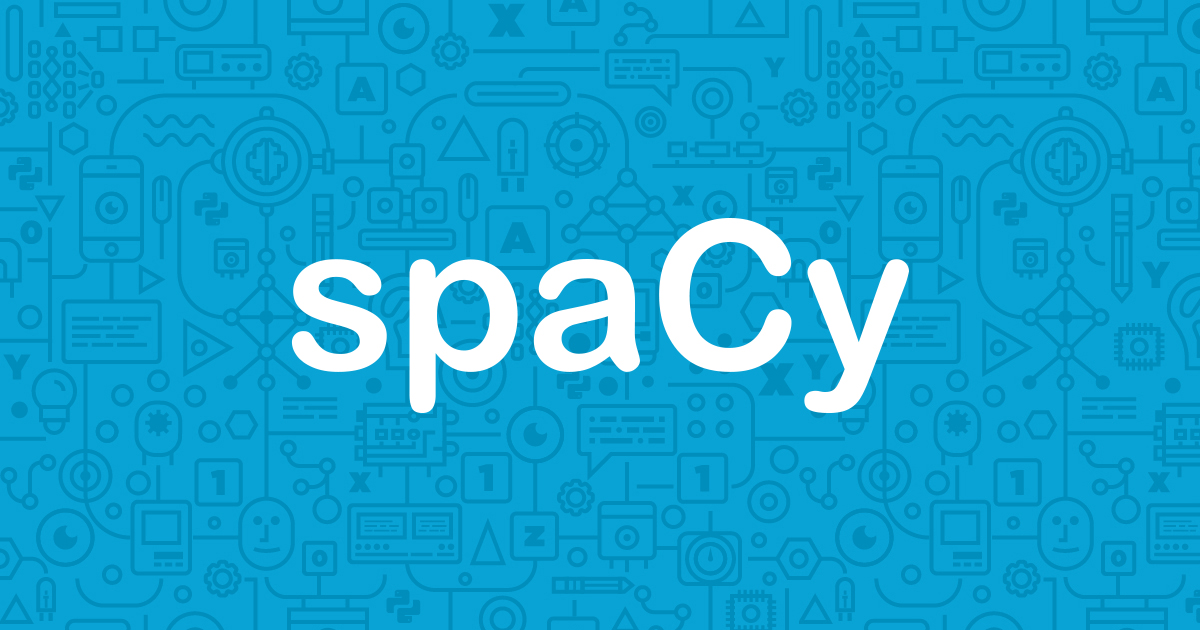

En esta notebook, vamos a ver **cómo entrenar desde cero un Text Categorizer** (es decir, un catergorizador de textos) para **predecir la pertenencia a una de dos clases**: positiva o negativa. Para eso, utilizaremos un dataset obtenido de Kaggle con 50.000 reseñas, de las cuales 25.000 pertenecen a cada clase -por lo que es un dataset balanceado-. Pueden encontrar el archivo en [este link](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

Además, aprovecharemos el **componente predeterminado TextCat de spaCy** que nos permite alimentarlo con ejemplos etiquetados de entrenamiento para luego generalizar en base a ellos y predecir el contenido de textos nunca antes vistos por el modelo.

***

## Librerías

En este ejercicio, vamos a importar y utilizar tres librerías: **Pandas para crear y manipular el objeto DataFrame**, **NumPy para el cómputo algunas de estas manipulaciones** y **spaCy para utilizar su pipeline y el modelo de TextCat**.

In [1]:
# Librerías

import pandas as pd
import numpy as np
import spacy

## Objetos y componentes

Para entrenar un Text Categorizer primero necesitamos... bueno, importar el Text Categorizer. El TextCat es un componente predeterminado y viene en dos variedades: single label y multilabel. Pueden aprender más sobre ellos en la [documentación](https://spacy.io/api/textcategorizer).

En este caso, **opté por la multilabel porque admite una única categoría -o más- mientras que single label admite exactamente dos**, y para clasificar en positivo o negativo una de las maneras que más me gusta es **asignar una única categoría llamada "sentiment" cuyo valor es 1 para reseñas positivas y 0 para reseñas negativas** (esta es una de las posibles maneras de encarar este desafío, pero sin duda no la única).

Además, necesitamos el **objeto Example**, incorporado en una actualización de spaCy 3.0. Previamente, los ejemplos se creaban como una lista por comprensión que luego se utilizaba para el ciclo de entrenamiento. Con la actualización, **spaCy agregó este objeto que toma la información necesaria y se la alimenta al componente a entrenar**.

In [2]:
# Importamos el componente del pipeline y el objeto example

from spacy.training import Example
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL

## Preprocesamiento de los datos

Para poder entrenar un TextCat, primero tenemos que **crear un pipeline de spaCy** con sus componentes predeterminados (recordemos que estos son: tokenizador, tagger, parser, attribute ruler, lemmatizer y NER) y luego **incorporar el TextCat** a esta serie de pasos. De esta manera, **el pipeline tomará como uno de los pasos del trabajo con un texto la asignación de una categoría** además de los pasos detallados. También debemos agregar la etiqueta al TextCat. Para este ejemplo, agregamos una única etiqueta llamada "sentiment" que podrá tomar un valor de 1 para reseñas positivas y un valor de 0 para las negativas.

Luego debemos -como es usual- **preprocesar los datos para que estén etiquetados para el entrenamiento del modelo**. Lo primordial es contar con **reseñas adecuadamente etiquetadas** que le permitan generalizar al modelo: el texto de la reseña y su correspondiente sentimiento (positivo o negativo). En este dataset, ese trabajo ya está realizado, pero si quisieramos trabajar con datos propios primero deberíamos realizar este trabajo de anotación.

En tercer lugar, tenemos que **crear la lista de datos de entrenamiento en un formato**. Más adelante veremos cómo se realiza este trabajo y cuál es el formato indicado para esta tarea. Una vez concluidos estos pasos, podemos proceder al entrenamiento de nuestro modelo.

In [3]:
# Creamos el objeto NLP

nlp = spacy.load('en_core_web_md')

In [4]:
# Observamos los nombres de los componentes del pipeline

nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [5]:
# Definimos la configuración del TextCat y agregamos el componente al pipeline

config = {"threshold":0.5,
         "model": DEFAULT_MULTI_TEXTCAT_MODEL}


textcat = nlp.add_pipe("textcat_multilabel", config=config)

In [6]:
# Corroboramos que se haya agregado correctamente

nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'textcat_multilabel']

In [7]:
# Agregamos la etiqueta al textcat

textcat.add_label("sentiment")

1

In [8]:
# Corroboramos que la etiqueta se haya agregado correctamente

textcat.labels

('sentiment',)

In [55]:
# Creamos el DataFrame

df = pd.read_csv('IMDB Dataset.csv')

In [56]:
# Observamos el DataFrame

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [11]:
# Creamos una columna para codificar el sentimiento positivo como 1 y el negativo como 0

df['sentiment_coded'] = np.where(df['sentiment'] == 'positive', 1, 0)

In [ ]:
# Corroboramos que la columna 'sentiment_coded' se haya creado correctamente

df

In [12]:
# Chequeamos si el dataset efectivamente está balanceado

df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Formateo de los datos de entrenamiento

Como dijimos previamente, para poder entrenar el TextCat, al igual que con cualquier modelo de machine learning, tenemos que **crear los datos de entrenamiento**.

El formato que debe respetar es (¡paciencia si no se entiende, abajo está detallado!): una lista de tuplas que contienen el texto de la reseña y un diccionario que tenga como key "cats" (por categoría) y como value otro diccionario anidado con la key "sentiment" y su correspondiente value 1 o 0 según si es positivo o negativo respectivamente.

¿Por qué hacemos esto? Porque **este formato es el que nos permite crear el objeto Example para alimentar al componente TextCat con los ejemplos necesarios para generalizar adecuadamente**. Ahora prodecederemos a crear esta data.

In [13]:
# Creamos la data de entrenamiento para el TextCat

train_data = list(zip(df['review'], df['sentiment_coded']))

In [14]:
# Observamos la data de entrenamiento. Nótese que se trata de una lista de tuplas que contienen el texto y el sentimiento

train_data

[("One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the 

In [15]:
# Creamos la lista en el formato correspondiebte para luego convertirlas en objetos Example
# El formato es (text, {'cats': {'sentiment': sent}}), en donde sent es 1 o 0 y text es el texto de la reseña

train_data= [(valor_col_1, {'cats':{'sentiment': valor_col_2} if valor_col_2 == 1 else {'sentiment': 0}}) for valor_col_1, valor_col_2 in 
             list(zip(df['review'].values, df['sentiment_coded'].values))]

In [16]:
# Corroboramos que se haya creado correctamente cada dato de entrenamiento

train_data[2], df.sentiment[2]

(('I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.',
  {'cats': {'sentiment': 1}}),
 'positive')

In [45]:
# Separamos nuestros datos de entrenamiento
# Idealmente usaríamos más datos pero quise acotar los tiempos de entrenamiento (que igual son LARGOS)

train = train_data[:4000]

In [113]:
# Chequeamos que estén razonablemente bien balanceados los datos

df[:4000]['sentiment'].value_counts()

negative    2027
positive    1973
Name: sentiment, dtype: int64

In [18]:
# Creamos la lista de objetos Example

examples = [Example.from_dict(nlp.make_doc(text), label) for text, label in train]

## Entrenamiento del modelo

Con la lista de objetos Example ya creada y los datos separados en entrenamiento y testeo, podemos proceder a entrenar el TextCat. Para ellos, primero inicializaremos el textcat con el método initialize() y le pasaremos como parámetros la lista de Example y el pipeline que queremos que utilice.

Luego **iniciaremos el loop de entrenamiento**. Definiremos una **cantidad de epochs** (cantidad de rondas de entrenamiento) y **alimentaremos al modelo con los ejemplos** que creamos hasta ahora para que los aprenda. **¡El proceso de entrenamiento tarda un buen rato!** No se sorprendan si llega a durar una hora o incluso más. Pueden jugar a reducir la cantidad de datos de entrenamiento o la cantidad de epochs, pero seguramente la precisión del modelo sufra a raíz de esos cambios.

In [19]:
# Inicializamos el componente TextCat con los ejemplos y el pipeline de spaCy

textcat.initialize(lambda: examples, nlp=nlp)

In [20]:
# Creamos el loop de entrenamiento con los objetos Example

import random

epochs = 20 #Cantidad de rondas de entrenamiento del modelo

with nlp.select_pipes(enable='textcat_multilabel'): #Deshabilitamos el resto de los componentes mientras entrenamos
    
    optimizer = nlp.resume_training() #Continúa entrenando un componente preentrenado
    
    for i in range(epochs):
        random.shuffle(train)
        for text, label in train:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, label)
            nlp.update([example], sgd=optimizer)

## Testeo del modelo

¡Listo! **Nuestro TextCat ya está entrenado**. A partir de ahora, cuando pasemos un texto por el objeto nlp() de spaCy, nos brindará un **número entre 0 y 1** en base a la predicción de categoría. Mientras el número sea más cercano a 1, más positiva será la reseña, y mientras más cercano a 0, más negativa. Para asignar la etiqueta, debemos definir nuestro umbral de clasificación (en este caso será 0.5).

Ahora, sólo nos queda testearlo con datos que todavía no vio. Para eso, utilizaremos un dataset test_data con las últimas 10.000 observaciones del DataFrame original.

In [94]:
test_data = df[40000:]

In [95]:
test_data

,review,sentiment
40000,First off I want to say that I lean liberal on...,negative
40001,I was excited to see a sitcom that would hopef...,negative
40002,When you look at the cover and read stuff abou...,negative
40003,"Like many others, I counted on the appearance ...",negative
40004,"This movie was on t.v the other day, and I did...",negative
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [96]:
# Observamos la predicción de la primera reseña

nlp(test_data['review'][40000]).cats

{'sentiment': 0.0003161187923979014}

In [97]:
# Observamos la predicción del modelo para las 10 primeras observaciones del dataset de testeo

for i in range(40000, 40010):
    print(nlp(test_data['review'][i]).cats)

{'sentiment': 0.0003161187923979014}
{'sentiment': 0.005246274638921022}
{'sentiment': 0.8423148989677429}
{'sentiment': 0.0016408524243161082}
{'sentiment': 0.002420332282781601}
{'sentiment': 0.9983347058296204}
{'sentiment': 0.9478076100349426}
{'sentiment': 0.001901627634651959}
{'sentiment': 0.6598595976829529}
{'sentiment': 0.0016131687443703413}


In [98]:
# Creamos una columna vacía para luego incorporar la categoría predicha por nuestro TextCat

test_data["prediccion"] = ""

C:\Users\valen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
# Observamos nuestro DataFrame

test_data

,review,sentiment,prediccion
40000,First off I want to say that I lean liberal on...,negative,
40001,I was excited to see a sitcom that would hopef...,negative,
40002,When you look at the cover and read stuff abou...,negative,
40003,"Like many others, I counted on the appearance ...",negative,
40004,"This movie was on t.v the other day, and I did...",negative,
...,...,...,...
49995,I thought this movie did a down right good job...,positive,
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,
49997,I am a Catholic taught in parochial elementary...,negative,
49998,I'm going to have to disagree with the previou...,negative,


In [100]:
# Populamos la columna 'prediccion' con el valor de la predicción del TextCat
# ¡Esto también puede tardar un rato, cada texto tiene que pasar por el objeto nlp()!

for i in test_data.index:
    test_data['prediccion'][i] = nlp(test_data['review'][i]).cats['sentiment']

C:\Users\valen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [101]:
# Observamos nuestro DataFrame

test_data

,review,sentiment,prediccion
40000,First off I want to say that I lean liberal on...,negative,0.000316119
40001,I was excited to see a sitcom that would hopef...,negative,0.00524627
40002,When you look at the cover and read stuff abou...,negative,0.842315
40003,"Like many others, I counted on the appearance ...",negative,0.00164085
40004,"This movie was on t.v the other day, and I did...",negative,0.00242033
...,...,...,...
49995,I thought this movie did a down right good job...,positive,0.996631
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0.000515048
49997,I am a Catholic taught in parochial elementary...,negative,0.478241
49998,I'm going to have to disagree with the previou...,negative,0.983914


In [102]:
# Definimos nuestro umbral. En este caso, si el valor de la categoría es superior a 0.5, consideramos que es positiva.
# Si es 0.5 o menos, la clasificamos como negativa

test_data['categoria_prediccion'] = np.where(test_data['prediccion'] > 0.5, 'positive', 'negative')

C:\Users\valen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [103]:
# Observamos nuestro DataFrame

test_data

,review,sentiment,prediccion,categoria_prediccion
40000,First off I want to say that I lean liberal on...,negative,0.000316119,negative
40001,I was excited to see a sitcom that would hopef...,negative,0.00524627,negative
40002,When you look at the cover and read stuff abou...,negative,0.842315,positive
40003,"Like many others, I counted on the appearance ...",negative,0.00164085,negative
40004,"This movie was on t.v the other day, and I did...",negative,0.00242033,negative
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,0.996631,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0.000515048,negative
49997,I am a Catholic taught in parochial elementary...,negative,0.478241,negative
49998,I'm going to have to disagree with the previou...,negative,0.983914,positive


In [106]:
# Hacemos un chequeo para corroborar que la categoría predicha coincida con la categoría etiquetada del dataset

test_data['chequeo_precision'] = np.where(test_data["sentiment"] == test_data["categoria_prediccion"], True, False)

C:\Users\valen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [107]:
# Observamos nuestro DataFrame

test_data

,review,sentiment,prediccion,categoria_prediccion,chequeo_precision
40000,First off I want to say that I lean liberal on...,negative,0.000316119,negative,True
40001,I was excited to see a sitcom that would hopef...,negative,0.00524627,negative,True
40002,When you look at the cover and read stuff abou...,negative,0.842315,positive,False
40003,"Like many others, I counted on the appearance ...",negative,0.00164085,negative,True
40004,"This movie was on t.v the other day, and I did...",negative,0.00242033,negative,True
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,0.996631,positive,True
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0.000515048,negative,True
49997,I am a Catholic taught in parochial elementary...,negative,0.478241,negative,True
49998,I'm going to have to disagree with the previou...,negative,0.983914,positive,False


In [108]:
# Contamos los valores individuales de la columna de chequeo de precisión

test_data['chequeo_precision'].value_counts()

True     8550
False    1450
Name: chequeo_precision, dtype: int64

## Conclusión

Como vemos, en este ejemplo nuestro TextCat predijo 8.550 de las 10.000 reseñas de testeo correctamente y 1.450 de manera incorrecta. Esto nos da una **precisión del 85,5%**. ¡Bastante bien! Más si consideramos que en sí el código para entrenar este TextCat es bastante breve y simple y el proceso de entrenamiento suele tardar menos de una hora.

Algunas consideraciones:

* Muchas veces en las reseñas utilizan **lenguaje ambiguo o sarcasmo** para enfatizar sus argumentos. Por lo general, las aplcaciones de NLP **tienen problemas para detectar este uso tan particular del idioma** y por ende suele clasificar erróneamente.
* En los casos de **predicciones muy cercanas al umbral de 0.5, una o dos palabras pueden hacer la diferencia** entre que sea clasificada como positiva o negativa. Siempre vamos a tener un pequeño margen de error en estas situaciones.
* Nuestro dataset de entrenamiento constaba de 4.000 ejemplos, pero nos quedaron 36.000 afuera (o más si quisiéramos reducir nuestro dataset de testeo). **Agregar más ejemplos incrementa sustancialmente el tiempo de entrenamiento, pero produce mejoras en la precisión**.

¡Y eso es todo! Ahora ya tienen un pantallazo general de cómo entrenar un clasificador de texto en spaCy. En base a esto, pueden scrapear sus propias reseñas de IMBD sobre sus películas favoritas y pasarlas por este clasificador de texto para ver si las predice correctamente.